In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from transformers import BertModel, BertTokenizer
from PIL import Image
import requests
from io import BytesIO

In [ ]:
#model
class ImageEncoder(nn.Module):
    
    def __init__(self,embed_dim):
        super().__init__();
        resnet = models.resnet50(pretrained=True)
        
        #为什么要删除最后一层全连接层？
        
        #因为Resnet50最后一层线性层输出的结果的通道数是1000（用于分类问题）
        #但是我们希望进一步抽离特征 使这一层的dim_out等于下一层网络的dim_in所以要去掉最后一层
        layers = list(resnet.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
        
    def forward(self, x):
    # 在特征提取部分禁用梯度计算 因为不需要在更改权重了
        # with torch.no_grad():
        features = self.feature_extractor(x)
        
        # 将特征从 [B, C, 1, 1] 形状调整为 [B, C]
        features = features.view(features.size(0), -1)
        
        # 将特征映射到嵌入维度，这部分是需要梯度计算的
        features = self.fc(features)
        return features

class TextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state[:, 0, :]  # 取[CLS]标记的输出
        features = self.fc(features)
        return features
    
class CLIPModel(nn.Module):
    def __init__(self, embed_dim):
        super(CLIPModel, self).__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)

    def forward(self, images, input_ids, attention_mask):
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(input_ids, attention_mask)
        
        # 归一化
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        
        return image_features, text_features


In [ ]:
import torch
from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 图像预处理函数
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    return preprocess(img).unsqueeze(0)

# 文本预处理函数
def preprocess_text(texts):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    return inputs['input_ids'], inputs['attention_mask']

# 计算相似性
def compute_similarity(model, image_path, texts):
    image = preprocess_image(image_path)
    input_ids, attention_mask = preprocess_text(texts)
    model.eval()
    with torch.no_grad():
        image_features, text_features = model(image, input_ids, attention_mask)
    similarity = torch.matmul(text_features, image_features.T)
    return similarity


image_path = "./images/bingbing.jpg"
texts = ["a photo of a cat", "a photo of a dog", "a photo of a horse"]

embed_dim = 512
model = CLIPModel(embed_dim)
similarity = compute_similarity(model, image_path, texts)

# 打印相似度矩阵
print("Similarity matrix:")
print(similarity)

# 找到每个图像最相似的文本描述
max_sim_indices = similarity.argmax(dim=0).cpu().numpy()
print("Max similarity indices:", max_sim_indices)

# 可视化结果
def visualize_results(image_path, texts, max_sim_indices):
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Predicted Text: {texts[max_sim_indices[0]]}")
    plt.show()

visualize_results(image_path, texts, max_sim_indices)


# CLIP verison_2

In [ ]:
#Model
class ImageEncoder(nn.Module):
    
    def __init__(self,embed_dim):
        super().__init__();
        resnet = models.resnet50(pretrained=True)
        
        #为什么要删除最后一层全连接层？
        
        #因为Resnet50最后一层线性层输出的结果的通道数是1000（用于分类问题）
        #但是我们希望进一步抽离特征 使这一层的dim_out等于下一层网络的dim_in所以要去掉最后一层
        layers = list(resnet.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
        
    def forward(self, x):
    # 在特征提取部分禁用梯度计算 因为不需要在更改权重了
        # with torch.no_grad():
        features = self.feature_extractor(x)
        
        # 将特征从 [B, C, 1, 1] 形状调整为 [B, C]
        features = features.view(features.size(0), -1)
        
        # 将特征映射到嵌入维度，这部分是需要梯度计算的
        features = self.fc(features)
        return features

class TextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state[:, 0, :]  # 取[CLS]标记的输出
        features = self.fc(features)
        return features
    
class CLIPModel(nn.Module):
    def __init__(self, embed_dim):
        super(CLIPModel, self).__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)

    def forward(self, images, input_ids, attention_mask):
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(input_ids, attention_mask)
        
        # 归一化
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        
        return image_features, text_features


tensor([[0.9833, 0.0127, 0.0039]], grad_fn=<SoftmaxBackward0>)


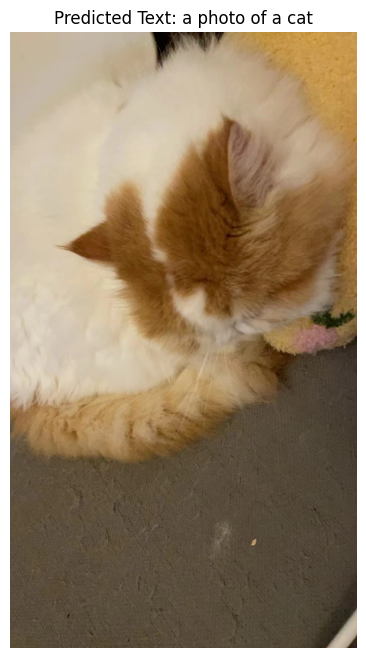

In [30]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# 加载 CLIP 模型和处理器
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 加载图像
image_path = "/home/dodo/wgm/CL/Clip/images/1.jpg"
image = Image.open(image_path)

# 文本描述
texts = ["a photo of a cat", "a photo of a dog","a photo of a horse"]

# 处理图像和文本
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

# 进行推理
outputs = model(**inputs)

# 获取图像和文本的相似度得分
logits_per_image = outputs.logits_per_image  # 这是图像相对于每个文本的相似度
probs = logits_per_image.softmax(dim=1)  # 将相似度转换为概率
max_sim_indices = probs.argmax(dim=0).cpu().numpy()
print(probs)  # 输出图像与每个文本描述的匹配概率

def visualize_results(image_path, texts, max_sim_indices):
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Predicted Text: {texts[max_sim_indices[0]]}")
    plt.show()

visualize_results(image_path, texts, max_sim_indices)
